Librerías

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

Conexión con base de datos

In [2]:
load_dotenv()


user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB_NAME')

url_conexion = f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{db}"


engine = create_engine(url_conexion)

Antes de empezar con el análisis y métricasa RFM, veremos el comportamientos generales de las ordenes

## Análisis de cantidad de compras a lo largo del tiempo

In [58]:
query_orders_date = """
SELECT 
    order_id,
    order_purchase_timestamp
FROM orders
WHERE order_status NOT IN ('canceled','unavailable')
"""
orders_date = pd.read_sql(query_orders_date,engine)

In [59]:
orders_date.isnull().sum()

order_id                    0
order_purchase_timestamp    0
dtype: int64

In [60]:
orders_date.dtypes

order_id                               str
order_purchase_timestamp    datetime64[us]
dtype: object

In [61]:
orders_date['order_purchase_timestamp'] = pd.to_datetime(orders_date['order_purchase_timestamp']).dt.normalize()
orders_date.head()

,order_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24
2,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13


In [62]:
pp_day = orders_date.resample('D', on='order_purchase_timestamp').order_id.count().reset_index()
pp_day.columns = ['timestamp', 'purchases']

<Axes: xlabel='purchases', ylabel='Count'>

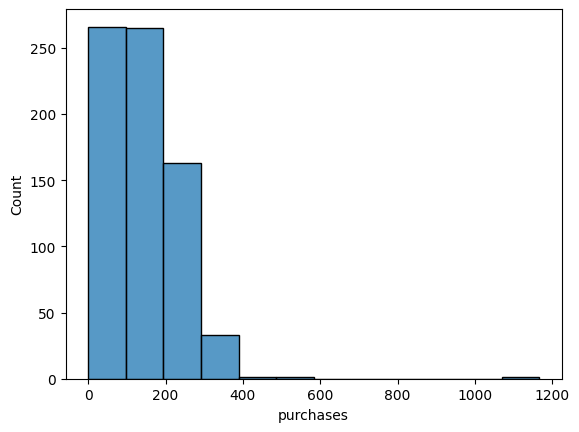

In [63]:
sns.histplot(pp_day, x= 'purchases', binwidth = 100)

Parece haber un punto claro punto atípico

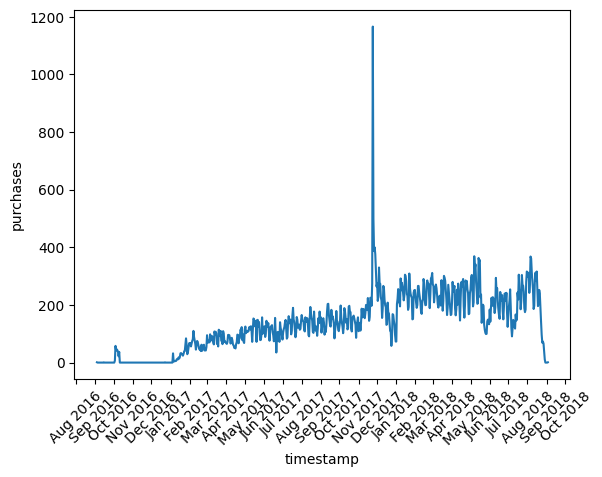

In [64]:
import matplotlib.dates as mdates

ax = sns.lineplot(data=pp_day, x='timestamp',y = 'purchases')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()



Se ve claramente una subida repentina en noviembre de 2017

In [65]:
max_p = pp_day.loc[pp_day['purchases'].idxmax()]
max_p.head()

timestamp    2017-11-24 00:00:00
purchases                   1166
Name: 446, dtype: object

Viendo que la fecha es el 11 de noviembre de 2017, nos damos cuenta que este outlier es consecuencia directa de black friday, este detalle debe ser tomado en cuenta con la métrica de receny, pues recordando nuestra fecha de referencia (17 de octubre de 2018), black friday fue hace 327 días, por lo que existe probabilidad de que varios compradores hayan realizado su **última o única** compra en Olist dicho día.

Si quitamos dicho punto atípico

<Axes: xlabel='purchases', ylabel='Count'>

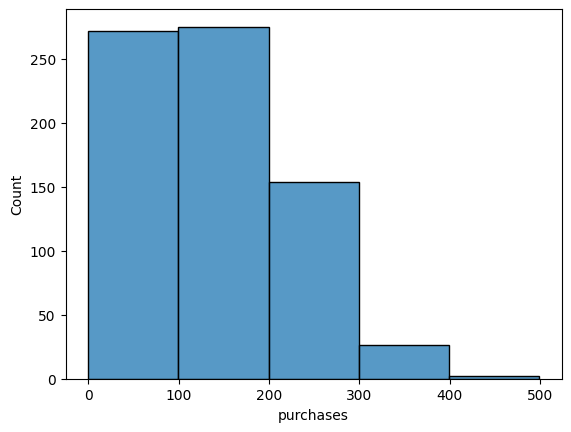

In [66]:
fix_max_p = pp_day[pp_day['purchases'] != 1166]

sns.histplot(data = fix_max_p, x = 'purchases', binwidth=100)

Si bien ya se ve más normalizado, parece seguir habiendo un punto atípico, si repetimos el proceso de gráfico y máximo

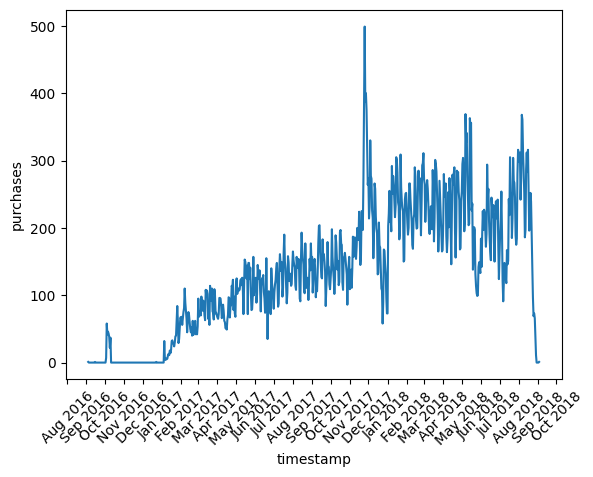

In [67]:
ax = sns.lineplot(data=fix_max_p, x='timestamp',y = 'purchases')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()

Este pico, también en noviembre probablemente sea la continuación del Black Friday, para analizar mejor estos outliers veamos lo 5 días con más ventas

In [68]:
sorted_purchases = fix_max_p.sort_values(by='purchases',ascending=False)
sorted_purchases.head()

,timestamp,purchases
447,2017-11-25,499
449,2017-11-27,400
448,2017-11-26,387
450,2017-11-28,376
610,2018-05-07,369


Como era de esperarse, estos encajan perfectamente, con la continuación del Black Friday de 2017, por lo que quitarlos para ver una tendencia "corriente" de la cantidad de compras podría ser adecuado para concluir este análisis

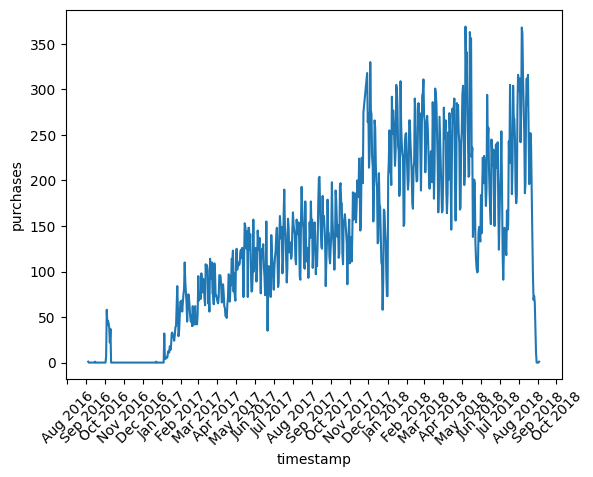

In [72]:
final_ppd = fix_max_p[fix_max_p['purchases'] < 376].copy()

ax = sns.lineplot(data = final_ppd, x='timestamp',y = 'purchases')

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.show()



Ahora se ve mucho más igualada, el alza de ventas tras cada cierto mes sea muy probablemente por la popularidad que fue adquiriendo Olist. En cuanto la baja de los últimos días probablemente sea más por los datos del dataset, por lo que no se debe tener mucho en cuenta.